In [31]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os
import glob

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

import sys
sys.path.append("../")
from utility_functions import *

In [12]:
# Define the path to store all the output results
output_dir = '/home/yinjx/kuafu/multi_array_combined_scaling/combined_strain_scaling_RM/EEW_tests'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [40]:
# # load the DAS channel location
# DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Ridgecrest_ODH3.txt')

# DAS_channel_num = DAS_info.shape[0]
# DAS_index = DAS_info[:, 0].astype('int')
# DAS_lon = DAS_info[:, 1]
# DAS_lat = DAS_info[:, 2]


#%% Specify the file names
DAS_info_files1 = '/kuafu/EventData/Mammoth_south/das_info.csv'
DAS_info_files2 = '/kuafu/EventData/Mammoth_north/das_info.csv'

DAS_info1 = pd.read_csv(DAS_info_files1)
DAS_info1.index = -DAS_info1.index # make the southern channel number negative
DAS_info2 = pd.read_csv(DAS_info_files2)
DAS_info = pd.concat([DAS_info1, DAS_info2], axis=0)

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info.index
DAS_lat = DAS_info['latitude']
DAS_lon = DAS_info['longitude']

center_lon = np.mean(DAS_lon)
center_lat = np.mean(DAS_lat)

Import the data, tried a few events

In [158]:
catalog_file =  '/kuafu/EventData/Mammoth_north/catalog.csv'
catalog = pd.read_csv(catalog_file)
catalog_select = catalog[(catalog.magnitude >= 4.5)] # choose the event with magnitude > 5

eq_num = catalog_select.shape[0]
print(f'Total number of events: {eq_num}')
catalog_select

Total number of events: 9


,event_id,event_time,longitude,latitude,depth_km,magnitude,magnitude_type,source
291,73481241,2020-11-13 09:13:51.580000+00:00,-117.820999,38.209667,17.930,5.35,Mw,NC
591,73491605,2020-12-01 23:32:56.420000+00:00,-118.060165,38.195999,12.210,4.96,Mw,NC
654,73492350,2020-12-03 05:15:29.760000+00:00,-118.056831,38.198502,17.020,4.78,Mw,NC
816,73496765,2020-12-12 07:50:52.940000+00:00,-118.077499,38.178501,11.120,4.77,Mw,NC
846,73497735,2020-12-14 21:20:10.880000+00:00,-118.115997,38.165165,9.800,4.81,Mw,NC
3263,73584926,2021-07-08 22:49:48.410000+00:00,-119.490730,38.510390,8.431,6.00,Mw,NCDD
3264,71123379,2021-07-08 22:50:14.370000+00:00,-119.502167,38.512667,7.400,5.03,Ml,NC
3287,73585021,2021-07-08 23:33:41.150000+00:00,-119.540510,38.481230,1.475,4.60,Mw,NCDD
3345,73585291,2021-07-09 01:46:00.710000+00:00,-119.520790,38.510170,8.340,4.50,Mw,NCDD


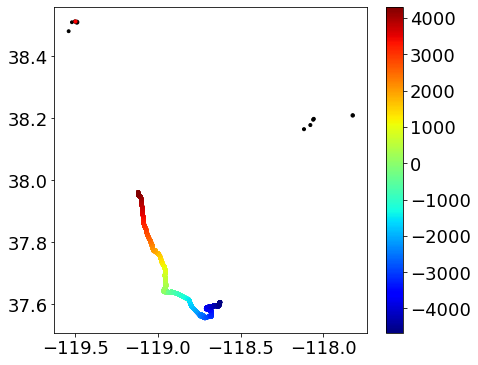

In [159]:
test_event_id = 71123379
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(catalog_select.longitude, catalog_select.latitude, s=10**(catalog_select.magnitude/5), c='k')
ii_eq = catalog_select.event_id == test_event_id
ax.scatter(catalog_select[ii_eq].longitude, catalog_select[ii_eq].latitude, s=10**(catalog_select[ii_eq].magnitude/5), c='r')

# AZ_BZN = [-116.667, 33.4915]
# CI_CCC = [-117.3645, 35.5249]
# ax.plot(CI_CCC[0], CI_CCC[1], 'gv', markersize=15)
fig.colorbar(cmp)

In [43]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)
    if kind is None:
        phase_index_extrap = np.ones(channel_all.shape) * -1
        phase_index_extrap[channel] = phase_index
        
    else:
        interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
        phase_index_extrap = interp_f(channel_all).astype('int')
    
    return phase_index_extrap

def std_filter(arrival_time, factor=10, fill_value=np.nan):
    mean_arrival, std_arrival = np.nanmean(arrival_time), np.nanstd(arrival_time)
    arrival_time[abs(arrival_time - mean_arrival) > factor * std_arrival] = fill_value
    return arrival_time
    
def median_filter(arrival_time, difference=10, fill_value=np.nan):
    median_arrival = np.nanmedian(arrival_time)
    arrival_time[abs(arrival_time - median_arrival) > difference] = fill_value
    return arrival_time

def load_phase_pick(pick_path, eq_id, das_time, channel, time_range=None, include_nan=False):
    picks = pd.read_csv(pick_path + f'/{eq_id}.csv')

    picks_P = picks[picks.phase_type == 'P'].drop_duplicates(subset=['channel_index'], keep='first')
    picks_S = picks[picks.phase_type == 'S'].drop_duplicates(subset=['channel_index'], keep='first')


    # Adding restriction on the time
    if time_range is not None:
        dt = das_time[1] - das_time[0]
        picks_P = picks_P[(picks_P.phase_type == 'P') & 
                            (picks_P.phase_index <= time_range[1]/dt) & 
                            (picks_P.phase_index >= time_range[0]/dt)]

        picks_S = picks_S[(picks_S.phase_type == 'S') & 
                            (picks_S.phase_index <= time_range[3]/dt) & 
                            (picks_S.phase_index >= time_range[2]/dt)]

    if include_nan:
        picks_P_time = np.ones(channel.shape) * np.nan
        picks_S_time = np.ones(channel.shape) * np.nan
        ii_p = channel.isin(picks_P.channel_index.unique())#picks_P.channel_index.isin(channel)
        ii_s = channel.isin(picks_S.channel_index.unique())#picks_S.channel_index.isin(channel)

        ii_p_picks = picks_P.channel_index.isin(channel)
        ii_s_picks = picks_S.channel_index.isin(channel)

        picks_P_time[ii_p] = das_time[picks_P.phase_index[ii_p_picks]]
        picks_S_time[ii_s] = das_time[picks_S.phase_index[ii_s_picks]]
        channel_P, channel_S = channel, channel

    else:
        picks_P_time = das_time[picks_P.phase_index]
        channel_P = channel[picks_P.channel_index]

        picks_S_time = das_time[picks_S.phase_index]
        channel_S = channel[picks_S.channel_index]

    return picks_P_time, channel_P, picks_S_time, channel_S


In [152]:
# path of the ML picking 
ml_pick_dir1 = '/kuafu/EventData/Mammoth_south/picks_phasenet_das'
ml_pick_dir2 = '/kuafu/EventData/Mammoth_north/picks_phasenet_das'

# CVM3D
cvm_tt_dir1 = '/kuafu/EventData/Mammoth_south/model_proc_tt/CVM3D'
cvm_tt_dir2 = '/kuafu/EventData/Mammoth_north/model_proc_tt/CVM3D'

# Check the segmented 50Hz data
data_path1 = '/kuafu/EventData/Mammoth_south/data'
data_path2 = '/kuafu/EventData/Mammoth_north/data'

time_range = (42, 60, 55, 72)

for eq_id_current in [test_event_id]:#eq_id:
    # load south event data
    event_data1, event_info = load_event_data(data_path1, eq_id_current)
    
    if event_data1.shape[1] > DAS_info1.shape[0]:
        event_data1 = event_data1[:, DAS_info1['index']]

    # load north event data
    event_data2, event_info = load_event_data(data_path2, eq_id_current)
    
    if event_data2.shape[1] > DAS_info2.shape[0]:
        event_data2 = event_data2[:, DAS_info2['index']]

    nt = event_data1.shape[0]
    das_time = np.arange(0, nt) * event_info['dt_s']

    event_data = np.concatenate([event_data1[:, ::-1], event_data2], axis=1)

    # load south ML picking
    pick_P1, channel_P1, pick_S1, channel_S1 = load_phase_pick(ml_pick_dir1, test_event_id, das_time, DAS_info1['index'], time_range, include_nan=True)

    # load north ML picking
    pick_P2, channel_P2, pick_S2, channel_S2 = load_phase_pick(ml_pick_dir2, test_event_id, das_time, DAS_info2['index'], time_range, include_nan=True)

    pick_P = np.concatenate([pick_P1[::-1], pick_P2])

    # load south CVM tt
    cvm_tt1 = pd.read_csv(f'{cvm_tt_dir1}/{test_event_id}.csv')
    channel_P1, cvm_tt_P1, cvm_tt_S1 = cvm_tt1.channel_index, cvm_tt1.tp+30, cvm_tt1.ts+30
    # load north CVM tt
    cvm_tt2 = pd.read_csv(f'{cvm_tt_dir2}/{test_event_id}.csv')
    channel_P2, cvm_tt_P2, cvm_tt_S2 = cvm_tt2.channel_index, cvm_tt2.tp+30, cvm_tt2.ts+30

    cvm_tt_P = np.concatenate([cvm_tt_P1[::-1], cvm_tt_P2])
    cvm_tt_S = np.concatenate([cvm_tt_S1[::-1], cvm_tt_S2])

Text(0.5, 0, 'Channel number (S-N)')

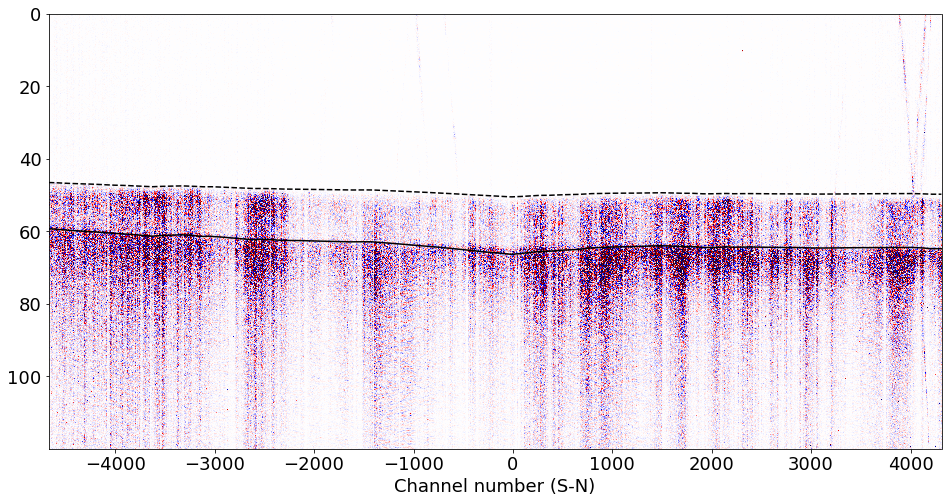

In [153]:
fig, ax1 = plt.subplots(figsize=(16,8))
pclip=99
clipVal = np.percentile(np.absolute(event_data), pclip)
# Vx
ax1.imshow(event_data, 
            extent=[-event_data1.shape[1], event_data2.shape[1], das_time[-1], das_time[0]],
            aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

ax1.plot(np.arange(-event_data1.shape[1], event_data2.shape[1]), cvm_tt_P, '--k')
ax1.plot(np.arange(-event_data1.shape[1], event_data2.shape[1]), cvm_tt_S, '-k')
ax1.set_xlabel('Channel number (S-N)')

Event 38548295 done!


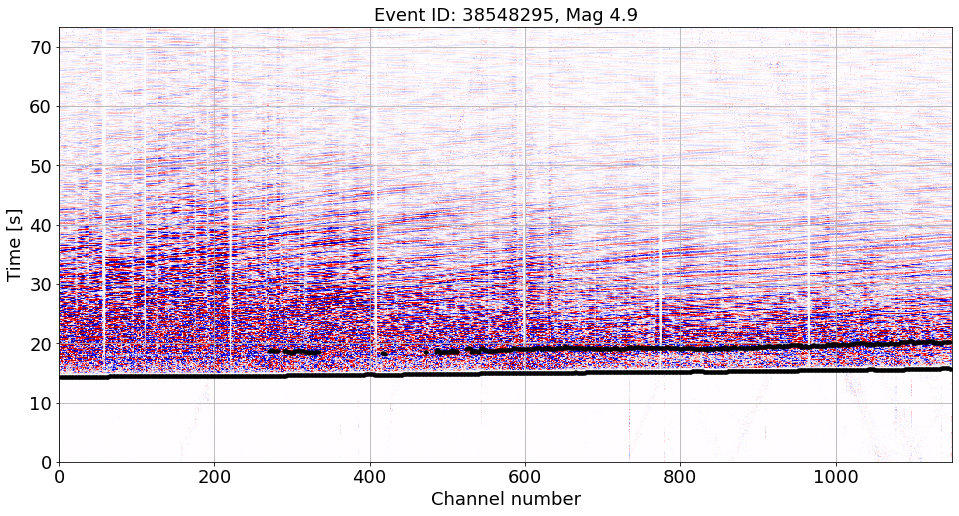

In [24]:

# # path of the ML picking 
# ml_pick_dir = '/kuafu/EventData/Mammoth_north/picks_phasenet_das'

# # Check the segmented 50Hz data
# data_path = '/kuafu/EventData/Mammoth_north/data'

# for eq_id_current in [test_event_id]:#eq_id:
#     event_data, event_info = load_event_data(data_path, eq_id_current)
    
#     if event_data.shape[1] > DAS_info1.shape[0]:
#         event_data = event_data[:, DAS_info1.index]

#     nt = event_data.shape[0]
#     das_time = np.arange(0, nt) * event_info['dt_s']


#     # look for the corresponding ML picks
#     ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
#     ml_picks = pd.read_csv(ml_picks_file[0])

#     # extract the picked information
#     ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
#     ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

#     # remove some duplicated picks, only keep those with higher probability
#     ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
#     ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
    
#     if extrapolate_ml_picking:
#         # extrapolate the index in case the ML picking is imcomplete
#         event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
#         event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
#         channel_of_picks_P = np.arange(DAS_channel_num)
#         channel_of_picks_S = np.arange(DAS_channel_num)
#         fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
#     else:
#         # not extrapolate the index in case the ML picking is imcomplete
#         event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
#         event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
#         channel_of_picks_P = ml_picks_p['station_name']
#         channel_of_picks_S = ml_picks_s['station_name']
#         fig_name = f'{eq_id_current}_ml.png'
    

    

#     # look for the corresponding data file
#     file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
#     temp = np.load(file_name[0], allow_pickle=True)
#     data_diff = temp[temp.files[0]]
#     eq_t0 = temp[temp.files[1]]
#     das_time_t0 = temp[temp.files[2]]
    
#     # time information 
#     das_time = np.arange(data_diff.shape[0]) * das_dt

#     # get the ML pick time
#     event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
#     event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

#     # Slight modify only for plotting purpose
#     event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
#     event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

#     # Filter out some obvious outliers based on STD
#     event_arrival_P_ml = std_filter(event_arrival_P_ml)
#     event_arrival_S_ml = std_filter(event_arrival_S_ml)

#     # Filter out some obvious outliers based on median
#     event_arrival_P_ml = median_filter(event_arrival_P_ml)
#     event_arrival_S_ml = median_filter(event_arrival_S_ml)

#     # Show data
#     fig, ax1 = plt.subplots(figsize=(16,8))
#     pclip=99.9
#     clipVal = np.percentile(np.absolute(data_diff), pclip)
#     # Vx
#     ax1.imshow(data_diff, 
#                 extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
#                 aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

#     ax1.plot(event_arrival_P_ml, '.k', linewidth=2, zorder=10)
#     ax1.plot(event_arrival_S_ml, '.k', linewidth=2, zorder=10)
    
#     ax1.set_title(f'Event ID: {eq_id_current}, Mag {event_mag.values[0]:.1f}')
#     ax1.set_xlabel("Channel number")
#     ax1.set_ylabel("Time [s]")
#     ax1.grid()
#     #ax1.set_ylim(10, 12)
#     ax1.invert_yaxis()

#     # plt.savefig(das_path + '/' + fig_name)
#     # plt.close('all')
#     print(f'Event {eq_id_current} done!')

    

In [13]:
eq_t0

array(UTCDateTime(2019, 7, 12, 13, 11, 37, 990000), dtype=object)

In [14]:
das_time_t0

array(UTCDateTime(2019, 7, 12, 13, 11, 29, 538792), dtype=object)

### Now assume that we have detected events and begin to use its arrival time curves to locate earthquake

In [116]:
# Load the calculated templates
temp = np.load('/kuafu/yinjx/Mammoth/arrival_time_matching/arrival_time_template.npz')
distance_to_source_all = temp['distance_grid']
lat_grid = temp['lat_grid']
lon_grid = temp['lon_grid']
event_arrival_P_template = temp['event_arrival_P']
event_arrival_S_template = temp['event_arrival_S']


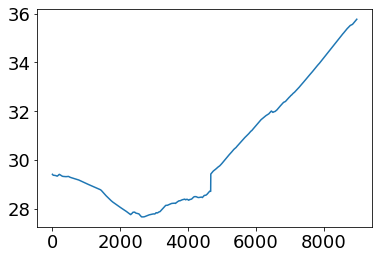

In [119]:
plt.plot(event_arrival_P_template[:, 50])

In [147]:
def match_arrival(event_arrival_observed, event_arrival_template, misfit_type='l1'):
    ii_nan = np.isnan(event_arrival_observed)
    event_arrival = event_arrival_observed[~ii_nan, np.newaxis]
    template = event_arrival_template[~ii_nan, :]

    # remove mean
    event_arrival = event_arrival - np.mean(event_arrival, axis=0, keepdims=True)
    template = template - np.mean(template, axis=0, keepdims=True)
    
    if misfit_type == 'l1':
        norm_diff = np.mean(abs(event_arrival - template), axis=0) # L1 norm
    elif misfit_type == 'l2':
        norm_diff = np.sqrt(np.mean((event_arrival - template)**2, axis=0)) # L2 norm
        
    ii_min = np.nanargmin(norm_diff)

    return ii_min, norm_diff

def misfit_to_probability(misfit):
    sigma_misfit = np.nanstd(misfit)
    probability = np.exp(-misfit**2/2/sigma_misfit**2)/sigma_misfit/np.sqrt(2*np.pi)
    probability = probability/np.nansum(probability)

    return probability
    

## Test locating with matching arrival time curves

In [121]:
# Define the path to store all the output results
figure_output_dir = output_dir + f'/{test_event_id}'
if not os.path.exists(figure_output_dir):
    os.mkdir(figure_output_dir)

In [27]:
distance_to_station = 23.56/111.3

In [155]:
# 0.25 s after starting time
def arrival_time_locating(time_after_detection, event_arrival_P_ml, event_arrival_P_template):

    event_arrival_P_obtained = event_arrival_P_ml.copy()
    ii_time = (event_arrival_P_obtained >= starting_time) & (event_arrival_P_obtained < starting_time + time_after_detection)
    event_arrival_P_obtained[~ii_time] = np.nan

    ii_min, norm_diff = match_arrival(event_arrival_P_obtained, event_arrival_P_template, misfit_type='l2')
    probability = misfit_to_probability(norm_diff)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 3]})

    gca = ax[0]
    gca.plot(event_arrival_P_ml, '.k')
    gca.plot(event_arrival_P_obtained, 'r.')
    gca.invert_yaxis()
    gca.set_ylabel('Time')
    gca.set_xlabel('Channels')
    gca.set_title(f'{time_after_detection:.2f} s after detection')

    gca = ax[1]
    cmp = gca.scatter(DAS_lon, DAS_lat, s=1, c='b')
    gca.plot(lon_grid.flatten(), lat_grid.flatten(), 'k+')
    gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=20, color='gold')
    gca.plot(event_lon, event_lat, 'r*', markersize=20)

    
    # gca.set_ylim(center_lat-1.1, center_lat+1.1)
    # gca.set_xlim(center_lon-1.1, center_lon+1.1)

    cbar = gca.scatter(lon_grid, lat_grid, s=800, c= np.reshape(probability, lon_grid.shape), cmap='gray', marker='s')
    gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)
    # gca.plot(event_test[5], event_test[4], 'r*', markersize=20)
    gca.set_title('P location')
    fig.colorbar(cbar, ax=gca, label='probability')

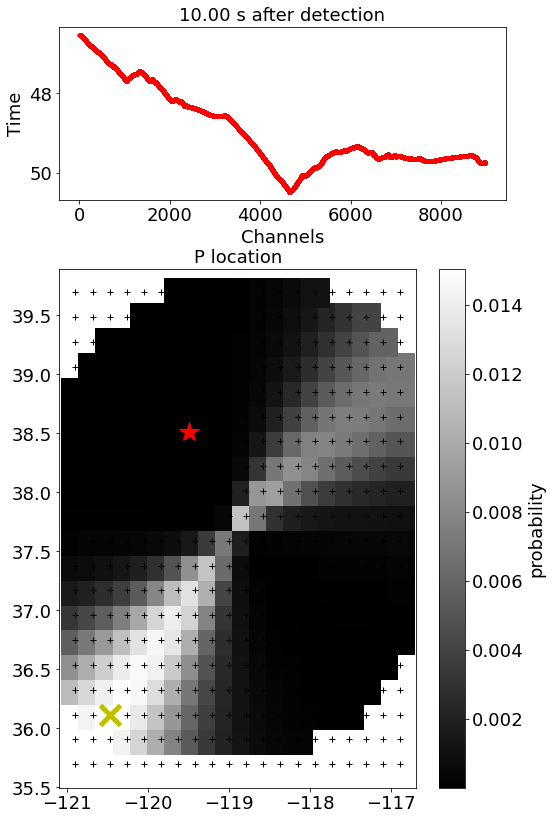

In [154]:
starting_time = np.nanmin(cvm_tt_P)
time_after_detection=10
event_arrival_P_obtained = cvm_tt_P.copy()
ii_time = (event_arrival_P_obtained >= starting_time) & (event_arrival_P_obtained < starting_time + time_after_detection)
event_arrival_P_obtained[~ii_time] = np.nan

ii_min, norm_diff = match_arrival(event_arrival_P_obtained, event_arrival_P_template, misfit_type='l2')
probability = misfit_to_probability(norm_diff)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 3]})

gca = ax[0]
gca.plot(cvm_tt_P, '.k')
gca.plot(event_arrival_P_obtained, 'r.')
gca.invert_yaxis()
gca.set_ylabel('Time')
gca.set_xlabel('Channels')
gca.set_title(f'{time_after_detection:.2f} s after detection')

gca = ax[1]
cmp = gca.scatter(DAS_lon, DAS_lat, s=1, c='b')
gca.plot(lon_grid.flatten(), lat_grid.flatten(), 'k+')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=20, color='gold')
gca.plot(event_lon, event_lat, 'r*', markersize=20)


# gca.set_ylim(center_lat-1.1, center_lat+1.1)
# gca.set_xlim(center_lon-1.1, center_lon+1.1)

cbar = gca.scatter(lon_grid, lat_grid, s=800, c= np.reshape(probability, lon_grid.shape), cmap='gray', marker='s')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)
# gca.plot(event_test[5], event_test[4], 'r*', markersize=20)
gca.set_title('P location')
fig.colorbar(cbar, ax=gca, label='probability')

In [146]:
norm_diff

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  4.2299829 ,  4.41229547,
        4.60514257,  4.80546031,  5.00898724,  5.21044744,  5.40399296,
        5.58386552,  5.74513837,  5.88433758,  5.99976866,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,  3.75546905,  3.91600521,  4.09355609,  4.28780315,
        4.49714251,  4.71829662,  4.94608582,  5.17354234,  5.39251434,
        5.59475207,  5.77322675,  5.92325043,  6.04300425,  6.13335235,
        6.19713285,  6.23826916,         nan,         nan,         nan,
        3.4441221 ,  3.58611831,  3.74775513,  3.93071705,  4.13582572,
        4.36237231,  4.60733469,  4.86469403,  5.12523323,  5.37

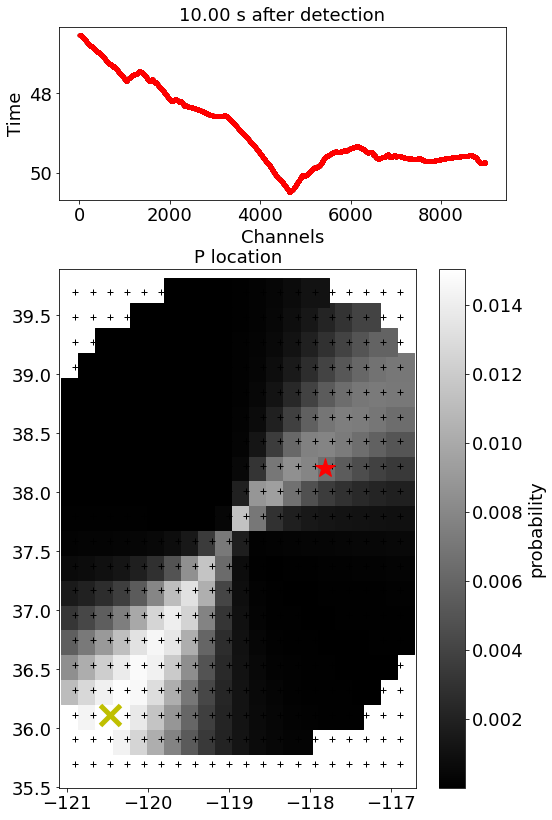

In [156]:
starting_time = np.nanmin(cvm_tt_P)
ii_eq = catalog_select.event_id == test_event_id
event_lon = catalog_select[ii_eq].longitude
event_lat = catalog_select[ii_eq].latitude

# 0.25 s after starting time
time_after_detection = 0.5
for time_after_detection in [10]:#np.arange(0.1, 2, 0.1):
    arrival_time_locating(time_after_detection, cvm_tt_P, event_arrival_P_template)
    # plt.savefig(figure_output_dir + f'/{time_after_detection:.1f}s_locating.png', bbox_inches='tight')
    # plt.close('all')

## Test magnitude estimation using the location estimation from above steps

In [14]:
pclip=90
clipVal = np.percentile(np.absolute(data_diff), pclip)

In [15]:
# Prepare the magnitude estimation parameters
import statsmodels.api as sm

#%% load the results from combined regional site terms t
results_output_dir = '/home/yinjx/kuafu/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate'#'/kuafu/yinjx/multi_array_combined_scaling/combined_strain_scaling_RO'
regression_dir = 'regression_results_smf'
site_term_column = 'region_site'
nearby_channel_number = 10

# load regression parameters
regP = sm.load(results_output_dir + '/' + regression_dir + f"/P_regression_combined_site_terms_{nearby_channel_number}chan.pickle")
#regS = sm.load(results_output_dir + '/' + regression_dir + f"/S_regression_combined_site_terms_{nearby_channel_number}chan.pickle")

temp2 = DAS_index // nearby_channel_number # combined channel number
site_term_keys = np.array([f'C(combined_channel_id)[{site_term}]' for site_term in temp2])
site_terms = np.array(regP.params[site_term_keys])
site_terms = site_terms[np.newaxis, :]

In [82]:
event_id_test_all

374     38548295
944     38593535
1345    38644943
1956    38996632
2888    39281440
3287    39462536
3396    39490952
3425    39493944
Name: 0, dtype: int64

In [19]:
for test_event_id in event_id_test_all:
    print(test_event_id)
    # Define the path to store all the output results
    figure_output_dir = output_dir + f'/{test_event_id}'
    if not os.path.exists(figure_output_dir):
        os.mkdir(figure_output_dir)

    event_test = catalog[catalog[0] == test_event_id]
    event_lon, event_lat = event_test[5], event_test[4]
    event_mag = event_test[7]

    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{test_event_id}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            
    except:
        print(f'ML picking {test_event_id} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{test_event_id}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        pclip=90
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Filter out some obvious outliers based on STD
        event_arrival_P_ml = std_filter(event_arrival_P_ml)
        event_arrival_S_ml = std_filter(event_arrival_S_ml)

        # Filter out some obvious outliers based on median
        event_arrival_P_ml = median_filter(event_arrival_P_ml)
        event_arrival_S_ml = median_filter(event_arrival_S_ml)
    except:
        continue

    starting_time = np.nanmin(event_arrival_P_ml)
    # Making figures
    for time_after_detection in np.arange(0.5, 10.5, 0.5):
        # Match location of earthquakes
        event_arrival_P_obtained = event_arrival_P_ml.copy()
        ii_time = (event_arrival_P_obtained >= starting_time) & (event_arrival_P_obtained <= starting_time + time_after_detection)
        event_arrival_P_obtained[~ii_time] = np.nan

        ii_min, norm_diff = match_arrival(event_arrival_P_obtained, event_arrival_P_template, misfit_type='l2')
        probability = misfit_to_probability(norm_diff)

        # Estimate magnitude
        distance_to_source_all_0 = distance_to_source_all * 113
        distance_to_source = distance_to_source_all_0[:, ii_min] 

        ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
        data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

        mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']
        mag_estimate_all = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source_all_0.T)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']
        mag_estimate_median = np.nanmedian(mag_estimate_all, axis=1)

        # combine location probability with the magnitude
        combined_mean = np.sum(mag_estimate_median * probability)

        # Plotting
        fig, ax = plt.subplots(2, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 3]})

        gca = ax[0]

        gca.imshow(data_diff[ii_time_array, :], 
                    extent=[0, data_diff.shape[1], das_time[ii_time_array][-1], das_time[ii_time_array][0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        gca.plot(event_arrival_P_ml, '.k')
        gca.plot(event_arrival_P_obtained, 'r.')
        gca.plot(event_arrival_S_ml, '.k')
        gca.set_ylim(starting_time - 0.5, starting_time + 10)
        gca.invert_yaxis()
        gca.set_ylabel('Time')
        gca.set_xlabel('Channels')
        gca.set_title(f'{time_after_detection} s after detection')

        gca = ax[1]
        cmp = gca.scatter(DAS_lon, DAS_lat, s=2, c='b')
        gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=25, color='gold')
        gca.plot(event_lon, event_lat, 'r*', markersize=10)
        # gca.set_ylim(center_lat-1.1, center_lat+1.1)
        # gca.set_xlim(center_lon-1.1, center_lon+1.1)

        cbar = gca.scatter(lon_grid, lat_grid, s=1200, c= np.reshape(probability, lon_grid.shape), cmap='hot', marker='s', alpha=0.5)
        gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)

        # for i_grid in range(len(mag_estimate_median)):
        #     gca.text(lon_grid.flatten()[i_grid], lat_grid.flatten()[i_grid], f'{mag_estimate_median[i_grid]:.1f}', 
        #     color='orange', fontsize=15, ha='center', va='center')
        CS = gca.contour(lon_grid, lat_grid, np.reshape(mag_estimate_median, lon_grid.shape), linewidths=3, 
                        levels=np.arange(1, 10, 0.5), cmap='brg')
        gca.clabel(CS, CS.levels, inline=True, fontsize=15)

        gca.text(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], f'{mag_estimate_median[ii_min]:.1f}', 
        color='red', fontsize=25, ha='center', va='center')

        gca.set_aspect('equal')
        gca.set_title(f'ID: {test_event_id}, M {event_mag.values[0]:.1f}')
        gca.set_xticks(np.arange(-119, -116, 0.5))

        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(gca)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(cbar, cax=cax, label='pdf',ticks=np.arange(0.01, 1.1, 0.01))

        plt.savefig(figure_output_dir + f'/{time_after_detection}s_prediction.png', bbox_inches='tight')
        plt.close('all')


38548295
38593535
38644943
38996632
39281440
39462536
39490952
39493944


In [91]:
figure_output_dir

'/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440'

In [25]:
import os
import moviepy.video.io.ImageSequenceClip
for test_event_id in event_id_test_all:
    print(test_event_id)
    image_folder = output_dir + f'/{test_event_id}'

    fps=2

    image_files = []
    for time_after_detection in np.arange(0.5, 10.5, 0.5):
        image_files.append(image_folder + f'/{time_after_detection}s_prediction.png')

    # image_files = [os.path.join(image_folder,img)
    #                for img in os.listdir(image_folder)
    #                if img.endswith(".png")]
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(image_folder + f'/{test_event_id}.mp4')
    clip.write_gif(image_folder + f'/{test_event_id}.gif')

38548295
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.gif with imageio.


38593535
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.gif with imageio.


38644943
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.gif with imageio.


38996632
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.gif with imageio.


39281440
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.gif with imageio.


39462536
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.gif with imageio.


39490952
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.gif with imageio.


39493944
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.gif with imageio.


In [88]:
ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)


In [96]:
distance_to_source = distance_to_source_all[:, ii_min] * 113

ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']


In [105]:
distance_to_source = distance_to_source_all * 113

ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source.T)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']


In [106]:
mag_estimate.shape

(100, 1150)

In [107]:
mag_estimate_median = np.nanmedian(mag_estimate, axis=1)

In [108]:
mag_estimate_median

array([ 5.60730987,  5.51803787,  5.43827742,  5.37926618,  5.34438063,
        5.34338571,  5.37518874,  5.43559087,  5.51403992,  5.60251934,
        5.46800936,  5.34790752,  5.23401957,  5.14073571,  5.08800744,
        5.08613179,  5.13834701,  5.22678155,  5.34007706,  5.45993235,
        5.3309754 ,  5.1686372 ,  5.00067695,  4.84756399,  4.74747465,
        4.74328705,  4.83705477,  4.98541001,  5.15297473,  5.3170342 ,
        5.211554  ,  4.99713316,  4.74755253,  4.47066877,  4.24463502,
        4.23460162,  4.45029313,  4.72770733,  4.97884727,  5.19419518,
        5.13916844,  4.88679624,  4.55429604,  4.07753615,  3.34632008,
        3.30060164,  4.04424185,  4.5267168 ,  4.86403579,  5.12206351,
        5.13759116,  4.88558882,  4.55262841,  4.07661991,  3.34537499,
        3.30442905,  4.04429936,  4.52550322,  4.86249161,  5.12051761,
        5.207473  ,  4.99414372,  4.74620819,  4.47041797,  4.24473976,
        4.23481642,  4.44811681,  4.72459785,  4.97718516,  5.19

In [1]:
fig, ax = plt.subplots(figsize=(10, 10))
gca = ax
cmp = gca.scatter(DAS_lon, DAS_lat, s=1, c='b')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=20, color='gold')
gca.plot(event_lon, event_lat, 'r*', markersize=20)
# gca.set_ylim(center_lat-1.1, center_lat+1.1)
# gca.set_xlim(center_lon-1.1, center_lon+1.1)

cbar = gca.scatter(lon_grid, lat_grid, s=800, c= np.reshape(np.exp(-norm_diff), lon_grid.shape), cmap='gray', marker='s')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)

for i_grid in range(len(mag_estimate_median)):
    gca.text(lon_grid.flatten()[i_grid], lat_grid.flatten()[i_grid], f'{mag_estimate_median[i_grid]:.1f}', 
    color='orange', fontsize=15, ha='center', va='center')
gca.contourf(lon_grid, lat_grid, mag_estimate_median)

# gca.plot(event_test[5], event_test[4], 'r*', markersize=20)
gca.set_title('P location')
fig.colorbar(cbar, ax=gca, label='probability')

NameError: name 'plt' is not defined

In [132]:
np.nansum(np.exp(-norm_diff).shape * mag_estimate_median)/ np.nansum(np.exp(-norm_diff).shape)/100

4.9658333663305463

In [131]:
np.exp(-norm_diff)

array([ 0.86754438,  0.88874115,  0.90580882,  0.90288213,  0.87272227,
        0.83236927,  0.7868311 ,  0.74631289,  0.71338212,  0.68860509,
        0.83933316,  0.8681501 ,  0.89487956,  0.90905769,  0.87791789,
        0.8263983 ,  0.76897388,  0.72237522,  0.68905647,  0.66637431,
        0.80736996,  0.83092095,  0.8690243 ,  0.90462933,  0.88680484,
        0.81519767,  0.74018937,  0.68968647,  0.66000604,  0.64229838,
        0.77716651,  0.78986085,  0.81515181,  0.87078817,  0.90385456,
        0.78934105,  0.69093672,  0.64814318,  0.62929976,  0.62004957,
        0.7573098 ,  0.75947496,  0.76447393,  0.78074713,  0.88320525,
        0.70069094,  0.6228742 ,  0.6112869 ,  0.60794723,  0.60659413,
        0.75623199,  0.75799031,  0.76227738,  0.77700735,  0.87571388,
        0.71112287,  0.62768397,  0.61433802,  0.61021527,  0.60842543,
        0.7742139 ,  0.78592282,  0.80970133,  0.86382546,  0.91669611,
        0.80457053,  0.70204545,  0.65639785,  0.63578689,  0.62

In [139]:
mag_estimate_median = np.nanmedian(mag_estimate, axis=1)